# Lane Detection with VGG-UNET Architecture

## Download Dataset

In [1]:
# !curl -L -o ~/Downloads/tusimple.zip\
#   https://www.kaggle.com/api/v1/datasets/download/manideep1108/tusimple

## Import Modules

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv
import random
import shutil
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# import dl libraries
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

/opt/miniconda3/envs/nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [3]:
IMAGE_FOLDER = 'tusimple_processed/images'
MASK_FOLDER = 'tusimple_processed/masks'

In [4]:
def create_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    else:
        print(f"Directory already exists: {path}")
        

In [5]:
create_if_not_exist(IMAGE_FOLDER)
create_if_not_exist(MASK_FOLDER)

Directory already exists: tusimple_processed/images
Directory already exists: tusimple_processed/masks


### Move clips to image directory

In [6]:
CLIPS_PATH = "tusimple/TUSimple/train_set/clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    # Skip .DS_Store files
    if clip_dir == '.DS_Store':
        continue
        
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)
    
    # Skip if not a directory
    if not os.path.isdir(clip_dir_path):
        continue
    
    print(f"Processing Clip: {clip_dir}")
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        # Skip .DS_Store files
        if frame_dir == '.DS_Store':
            continue
            
        frame_dir_path = os.path.join(clip_dir_path, frame_dir)
        
        # Skip if not a directory
        if not os.path.isdir(frame_dir_path):
            continue
            
        # Construct path to the specific image file
        image_path = os.path.join(frame_dir_path, '20.jpg')
        
        # Check if the image file exists
        if not os.path.isfile(image_path):
            continue

        temp = frame_dir_path.split('/')[-2:]  # get last 2 directory names
        new_file = f"{temp[0]}_{temp[1]}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_file)

        # copy the file
        shutil.copy(image_path, new_file_path)

Processing Clip: 0601
Processing Clip: 0313-1
Processing Clip: 0531
Processing Clip: 0313-2


In [7]:
# Check how many images were processed
image_count = len([f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jpg')])
print(f"Total images processed: {image_count}")

# Show some example filenames
if image_count > 0:
    example_files = os.listdir(IMAGE_FOLDER)[:5]
    print(f"Example filenames: {example_files}")

Total images processed: 3626
Example filenames: ['0313-2_62400.jpg', '0313-2_30420.jpg', '0313-1_11800.jpg', '0313-2_34120.jpg', '0313-1_780.jpg']


In [8]:
len(os.listdir(IMAGE_FOLDER))

3626

In [9]:
df1 = pd.read_json('tusimple/TUSimple/train_set/label_data_0313.json', lines=True)
df2 = pd.read_json('tusimple/TUSimple/train_set/label_data_0531.json', lines=True)
df3 = pd.read_json('tusimple/TUSimple/train_set/label_data_0601.json', lines=True)

df = pd.concat([df1, df2, df3])
df.head()

,lanes,h_samples,raw_file
0,"[[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg


In [10]:
# create function for generating masks
def generate_lane_mask(row, MASK_FOLDER):
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane=1, non-lane=0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv.polylines(
            mask,
            [lane_points],
            isClosed=False,
            color=(255, 255, 255),
            thickness=15
        )

    # generate mask filename
    temp = raw_file[:-7].split('/')[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv.imwrite(mask_filename_path, mask)


In [11]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_mask(row, MASK_FOLDER)

100%|██████████| 3626/3626 [00:07<00:00, 497.97it/s]


In [12]:
print(f"Total masks generated: {len(os.listdir(MASK_FOLDER))}")

Total masks generated: 3626


In [13]:
def visualize_image(image_name):

    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)

    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    mask = cv.imread(mask_path)

    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title("Road Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Road Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Ground truth mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.show()

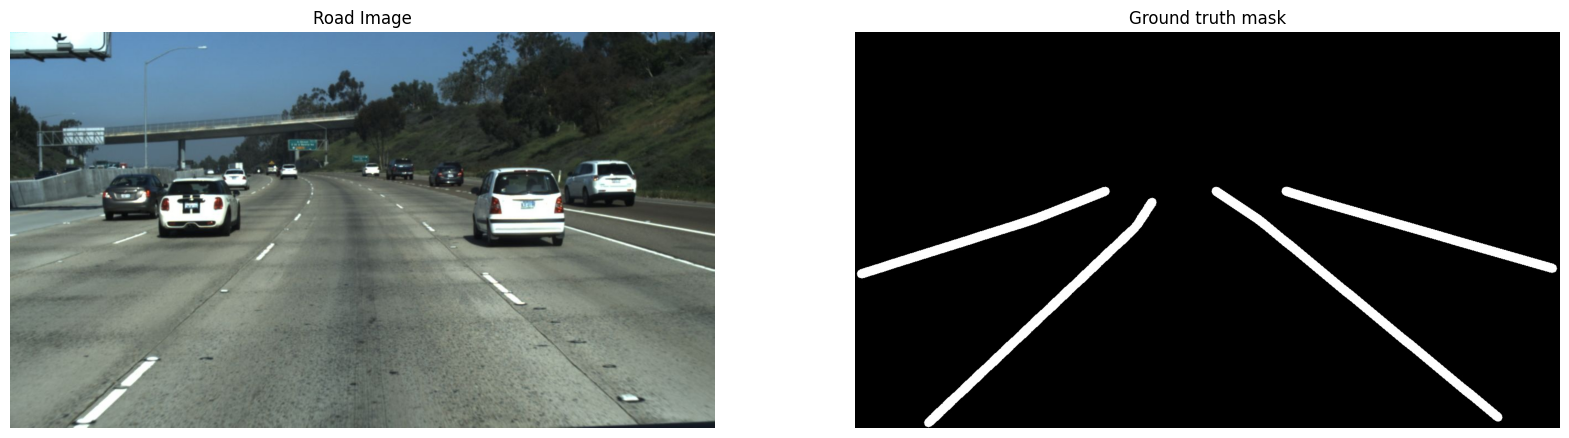

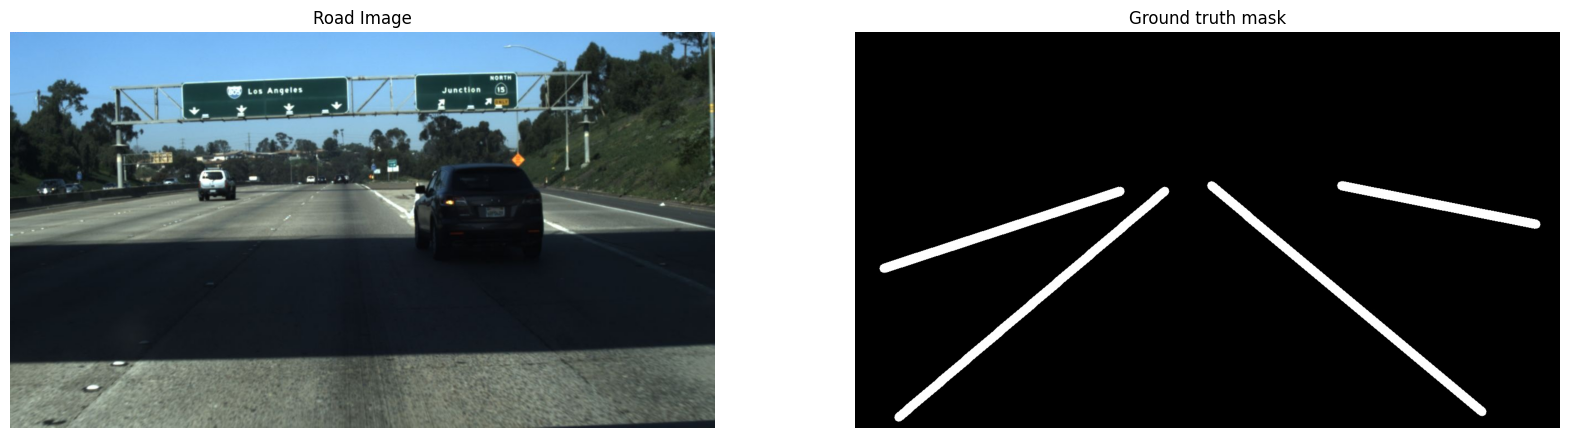

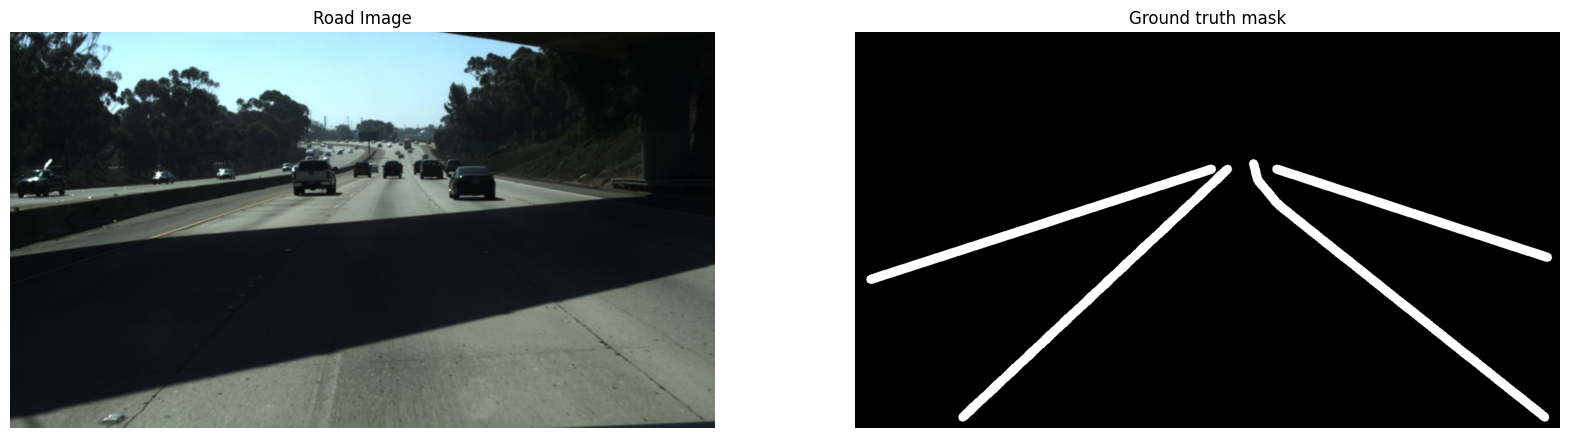

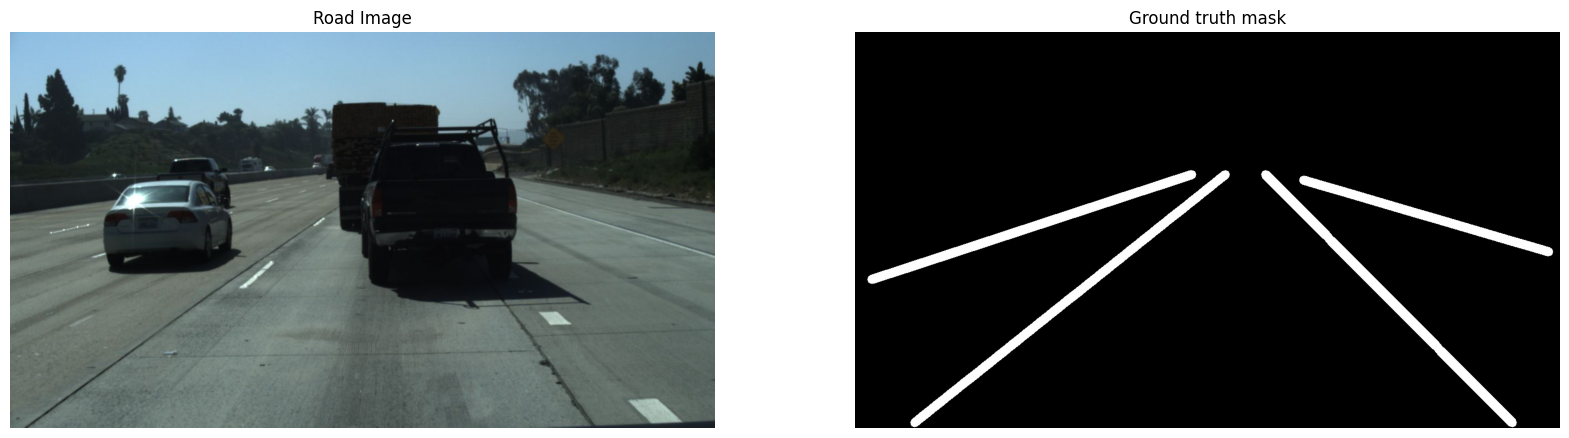

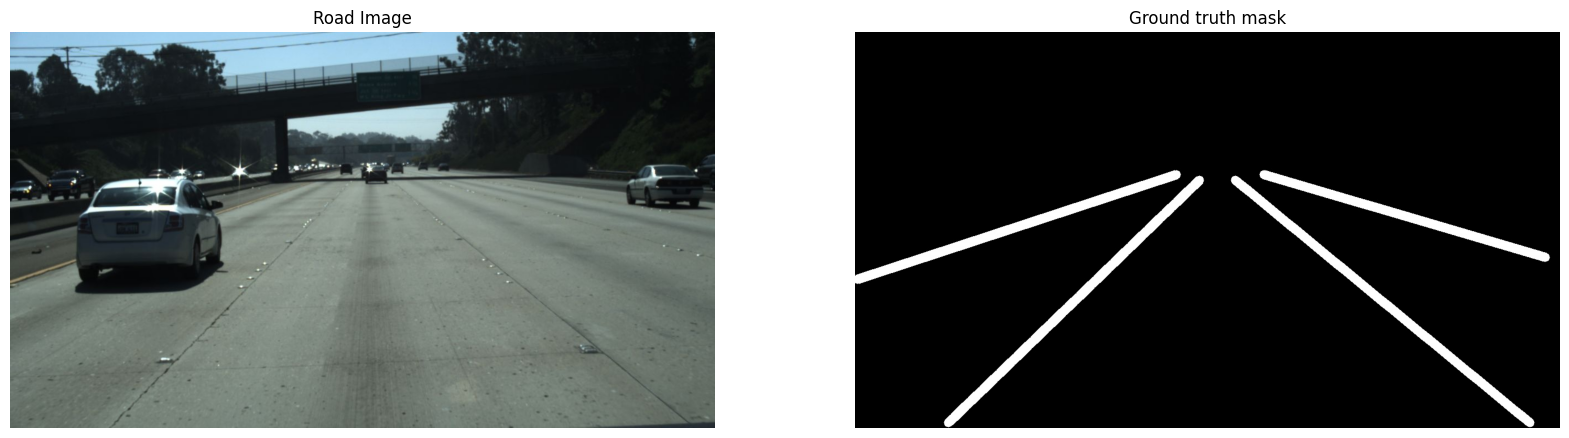

In [14]:
for _ in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

## Process data for training and testing

In [15]:
train_image_folder = 'tusimple_processed/train/images'
train_mask_folder = 'tusimple_processed/train/masks'

test_image_folder = 'tusimple_processed/test/images'
test_mask_folder = 'tusimple_processed/test/masks'

In [16]:
for path in [train_image_folder, train_mask_folder, test_image_folder, test_mask_folder]:
    create_if_not_exist(path)


Directory already exists: tusimple_processed/train/images
Directory already exists: tusimple_processed/train/masks
Directory already exists: tusimple_processed/test/images
Directory already exists: tusimple_processed/test/masks


In [17]:
from sklearn.model_selection import train_test_split

images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith('.jpg')]

train_image, test_image = train_test_split(images, test_size=0.2, random_state=42)


In [18]:
len(train_image), len(test_image)

(2900, 726)

In [19]:
for file in train_image:
    shutil.move(os.path.join(IMAGE_FOLDER, file), os.path.join(train_image_folder, file))
    shutil.move(os.path.join(MASK_FOLDER, file), os.path.join(train_mask_folder, file))

for file in test_image:
    shutil.move(os.path.join(IMAGE_FOLDER, file), os.path.join(test_image_folder, file))
    shutil.move(os.path.join(MASK_FOLDER, file), os.path.join(test_mask_folder, file))

In [20]:
def count_images_in_folder(folder):
    if not os.path.exists(folder):
        print(f"Folder not found: {folder}")
        return 0
    exts = ('.jpg', '.jpeg', '.png', '.bmp')
    return sum(1 for f in os.listdir(folder) if f.lower().endswith(exts))

train_imgs = count_images_in_folder(train_image_folder)
train_masks = count_images_in_folder(train_mask_folder)
test_imgs = count_images_in_folder(test_image_folder)
test_masks = count_images_in_folder(test_mask_folder)

print(f"Train images: {train_imgs}")
print(f"Train masks:  {train_masks}")
print(f"Test images:  {test_imgs}")
print(f"Test masks:   {test_masks}")

# quick sanity checks
if train_imgs != train_masks:
    print(f"Warning: train images and masks count mismatch ({train_imgs} != {train_masks})")

if test_imgs != test_masks:
    print(f"Warning: test images and masks count mismatch ({test_imgs} != {test_masks})")

Train images: 2900
Train masks:  2900
Test images:  726
Test masks:   726


### Feature Engineering

In [21]:
class ImageMaskDataset(Dataset):
    def __init__(self, image_folder, mask_folder, size=(224, 224)):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.size = size

        # Sort to keep image-mask correspondence
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.jpg')])

        # Define transformations
        self.image_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),   # Converts to [0,1]
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),   # Converts to [0,1]
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")   # 3 channels
        mask = Image.open(mask_path).convert("L")     # 1 channel

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask


In [22]:
train_dataset = ImageMaskDataset(train_image_folder, train_mask_folder)

test_dataset = ImageMaskDataset(test_image_folder, test_mask_folder)

In [23]:

BATCH_SIZE = 32
BUFFER_SIZE = 1000  # used for shuffle in TF, not needed in PyTorch

# For training
train_loader = DataLoader(
    train_dataset,                   # your training dataset
    batch_size=BATCH_SIZE,
    shuffle=True,              # equivalent to dataset.shuffle()
    pin_memory=True,           # faster transfer to GPU
    drop_last=True             # similar to TF repeat/batch
)

# For testing/validation
test_loader = DataLoader(
    test_dataset,              # your test dataset
    batch_size=BATCH_SIZE,
    shuffle=False,             # no shuffle for test
    pin_memory=True
)


In [24]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))
    titles = ['Image', 'True Mask', 'Predicted Mask']
    to_pil = transforms.ToPILImage()  # converts tensor → PIL image for display
    
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        
        # handle tensor or numpy
        img = image_list[i]
        if isinstance(img, (list, tuple)):
            img = img[0]
        
        if hasattr(img, "detach"):  # if tensor
            img = img.detach().cpu()
        
        plt.imshow(to_pil(img))
        plt.axis('off')
    
    plt.show()


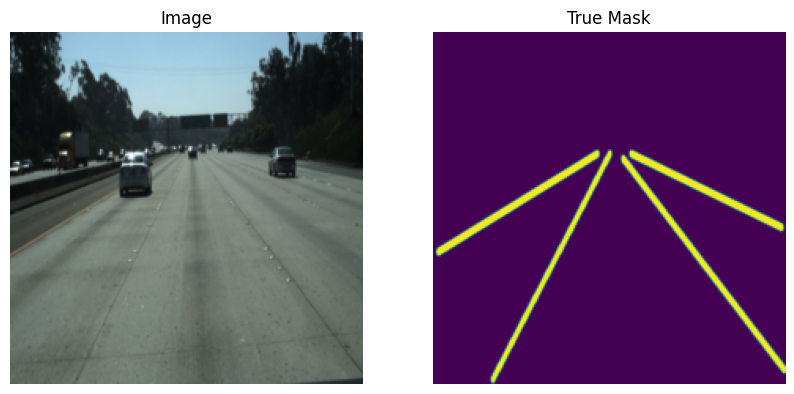

In [25]:
# get the first sample directly
image, mask = train_dataset[0]  
display_sample([image, mask])


## Model Creation - VGG-UNET

In [26]:
from torchvision.models import vgg16_bn
from torchvision.models import VGG16_BN_Weights
from torchinfo import summary

In [27]:
class Conv2DReluBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, strides=1):
        super().__init__()
        padding = kernel_size // 2  # Calculate padding for 'same' effect
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, 
                              stride=strides, padding=padding)
        self.elu = nn.ELU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.elu(x)
        x = self.bn(x)
        x = self.dropout(x)
        return x

In [33]:
class VGG16_UNet(nn.Module):
    def __init__(self, input_shape=(224, 224, 3)):
        super().__init__()
        # Load pre-trained VGG16 with BatchNorm
        vgg = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)
        
        # Extract VGG features without the final pooling and classifier
        features = list(vgg.features.children())
        
        # Encoder layers - use first 4 blocks only
        self.encoder1 = nn.Sequential(*features[:6])    # Conv block 1: 64 channels
        self.encoder2 = nn.Sequential(*features[7:13])  # Conv block 2: 128 channels  
        self.encoder3 = nn.Sequential(*features[14:23]) # Conv block 3: 256 channels
        self.encoder4 = nn.Sequential(*features[24:33]) # Conv block 4: 512 channels
        
        # Bottleneck (replaces encoder5)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Decoder layers - 4 blocks matching encoders
        self.up5 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv5 = Conv2DReluBatchNorm(512 + 512, 512)
        
        self.up6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv6 = Conv2DReluBatchNorm(256 + 256, 256)
        
        self.up7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv7 = Conv2DReluBatchNorm(128 + 128, 128)
        
        self.up8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv8 = Conv2DReluBatchNorm(64 + 64, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder with manual pooling to preserve feature maps
        e1 = self.encoder1(x)                    # 64 channels, 224x224
        e1_pool = nn.functional.max_pool2d(e1, 2, 2)  # 64 channels, 112x112
        
        e2 = self.encoder2(e1_pool)              # 128 channels, 112x112
        e2_pool = nn.functional.max_pool2d(e2, 2, 2)  # 128 channels, 56x56
        
        e3 = self.encoder3(e2_pool)              # 256 channels, 56x56
        e3_pool = nn.functional.max_pool2d(e3, 2, 2)  # 256 channels, 28x28
        
        e4 = self.encoder4(e3_pool)              # 512 channels, 28x28
        e4_pool = nn.functional.max_pool2d(e4, 2, 2)  # 512 channels, 14x14
        
        # Bottleneck
        b = self.bottleneck(e4_pool)             # 512 channels, 14x14

        # Decoder with skip connections
        d5 = self.up5(b)                         # 512 channels, 28x28
        d5 = torch.cat([d5, e4], dim=1)          # 1024 channels, 28x28
        d5 = self.conv5(d5)                      # 512 channels, 28x28

        d6 = self.up6(d5)                        # 256 channels, 56x56
        d6 = torch.cat([d6, e3], dim=1)          # 512 channels, 56x56
        d6 = self.conv6(d6)                      # 256 channels, 56x56

        d7 = self.up7(d6)                        # 128 channels, 112x112
        d7 = torch.cat([d7, e2], dim=1)          # 256 channels, 112x112
        d7 = self.conv7(d7)                      # 128 channels, 112x112

        d8 = self.up8(d7)                        # 64 channels, 224x224
        d8 = torch.cat([d8, e1], dim=1)          # 128 channels, 224x224
        d8 = self.conv8(d8)                      # 64 channels, 224x224

        out = self.final_conv(d8)                # 1 channel, 224x224
        out = self.sigmoid(out)
        
        return out

In [34]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [35]:
# Create model instance
model = VGG16_UNet(input_shape=(224, 224, 3)).to(device)


In [36]:
import torch.nn.functional as F

def dice_coefficient(y_true, y_pred):
    """Dice coefficient metric"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2.0 * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss function"""
    return 1 - dice_coefficient(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    """Recall metric"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    return intersection / (torch.sum(y_true_f) + 1e-7)

def precision_smooth(y_true, y_pred):
    """Precision metric"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    return intersection / (torch.sum(y_pred_f) + 1e-7)

def accuracy(y_true, y_pred):
    """Accuracy metric"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    
    # Convert to binary predictions (threshold at 0.5)
    y_pred_binary = (y_pred_f > 0.5).float()
    
    # True positives
    true_positives = torch.sum(y_true_f * y_pred_binary)
    
    # True negatives
    true_negatives = torch.sum((1 - y_true_f) * (1 - y_pred_binary))
    
    # Total pixels
    total_pixels = torch.numel(y_true_f)
    
    # Calculate accuracy
    accuracy_value = (true_positives + true_negatives) / total_pixels
    
    return accuracy_value

# Example usage with a PyTorch model
class DiceLoss(nn.Module):
    """Dice loss as a PyTorch Module for easier integration with training loops"""
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        return dice_loss(y_true, y_pred)



In [37]:
# Count total and trainable parameters of the existing `model`
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_params - trainable_params

def _fmt(n):
    if n >= 1e6:
        return f"{n/1e6:.2f}M"
    if n >= 1e3:
        return f"{n/1e3:.2f}K"
    return str(n)

print(f"Total parameters:       {total_params} ({_fmt(total_params)})")
print(f"Trainable parameters:   {trainable_params} ({_fmt(trainable_params)})")
print(f"Non-trainable params:   {non_trainable} ({_fmt(non_trainable)})")

Total parameters:       17933633 (17.93M)
Trainable parameters:   17933633 (17.93M)
Non-trainable params:   0 (0)


Sample index: 275, filename: 0313-1_16420.jpg
Image shape: torch.Size([3, 224, 224]), Mask shape: torch.Size([1, 224, 224]), Pred shape: torch.Size([1, 224, 224])


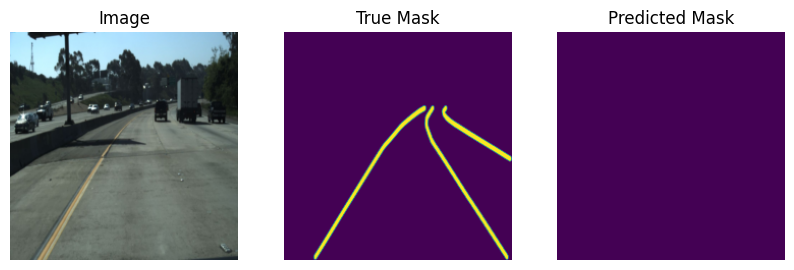

In [33]:
import torch

# Pick a random single sample from the training dataset, run through the model and visualize + print metrics.

# select random index
idx = random.randrange(len(train_dataset))
image, mask = train_dataset[idx]         # image: (3,H,W), mask: (1,H,W)
fname = train_dataset.image_files[idx]

# prepare input batch and run model
model.eval()
with torch.no_grad():
    inp = image.unsqueeze(0).to(device)      # (1,3,H,W)
    pred = model(inp)                        # (1,1,H,W)
    pred_prob = pred.detach().cpu()
    pred_bin = (pred_prob > 0.5).float()     # thresholded prediction

# squeeze batch dim for display/metrics: keep channel dim (1,H,W)
pred_prob_s = pred_prob.squeeze(0)           # (1,H,W)
pred_bin_s = pred_bin.squeeze(0)             # (1,H,W)

# Print info and metrics
print(f"Sample index: {idx}, filename: {fname}")
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Pred shape: {pred_prob_s.shape}")

# visualize image, true mask and predicted mask
display_sample([image, mask, pred_bin_s])

In [34]:
len(train_loader), len(test_loader)

(90, 23)

In [35]:
def train_loop(model, train_loader, optimizer, loss, device, epoch=None):
    model.train()
    train_loss = 0
    
    # Create progress bar for batches
    progress_bar = tqdm(enumerate(train_loader), 
                       total=len(train_loader),
                       desc=f"Epoch {epoch+1}" if epoch is not None else "Training",
                       leave=False)

    for batch_idx, (images, masks) in progress_bar:
        images, masks = images.to(device), masks.to(device)

        # forward pass
        outputs = model(images)

        # calculate loss
        loss_value = loss(outputs, masks)
        train_loss += loss_value.item()

        # zero grad
        optimizer.zero_grad()
        
        # backward pass
        loss_value.backward()

        # optimizer step
        optimizer.step()
        
        # Update progress bar with current loss
        current_avg_loss = train_loss / (batch_idx + 1)
        progress_bar.set_postfix({
            'batch_loss': f'{loss_value.item():.4f}',
            'avg_loss': f'{current_avg_loss:.4f}'
        })

    train_loss /= len(train_loader)
    return train_loss

In [36]:
def test_loop(model, test_loader, loss, device, epoch=None):
    model.eval()
    test_loss = 0
    
    # Create progress bar for validation batches
    progress_bar = tqdm(enumerate(test_loader), 
                       total=len(test_loader),
                       desc=f"Validation Epoch {epoch+1}" if epoch is not None else "Validation",
                       leave=False)

    with torch.inference_mode():
        for batch_idx, (images, masks) in progress_bar:
            images, masks = images.to(device), masks.to(device)

            # forward pass
            outputs = model(images)

            # calculate loss
            loss_value = loss(outputs, masks)
            test_loss += loss_value.item()
            
            # Update progress bar with current loss
            current_avg_loss = test_loss / (batch_idx + 1)
            progress_bar.set_postfix({
                'batch_loss': f'{loss_value.item():.4f}',
                'avg_loss': f'{current_avg_loss:.4f}'
            })

    test_loss /= len(test_loader)
    return test_loss

In [37]:
def train(model, train_loader, test_loader, optimizer, loss, device, epochs):
    results = {"train_loss": [], "test_loss": []}
    
    print(f"Starting training for {epochs} epochs...")
    print("=" * 50)

    for epoch in tqdm(range(epochs), desc="Overall Progress"):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)
        
        # Training phase
        train_loss = train_loop(model, train_loader, optimizer, loss, device, epoch)
        
        # Validation phase
        test_loss = test_loop(model, test_loader, loss, device, epoch)

        # Print epoch summary
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Test Loss:  {test_loss:.4f}")
        
        # Convert to Python float if it's a tensor
        train_loss_val = train_loss.item() if hasattr(train_loss, 'item') else train_loss
        test_loss_val = test_loss.item() if hasattr(test_loss, 'item') else test_loss
        
        results["train_loss"].append(train_loss_val)
        results["test_loss"].append(test_loss_val)

    print("\n" + "=" * 50)
    print("Training completed!")
    return results

In [39]:
class LightVGG16_UNet(nn.Module):
    def __init__(self, input_shape=(224, 224, 3), base_channels=32):
        super().__init__()
        
        # Encoder with batch normalization
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True)
        )
        
        self.encoder4 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, 3, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*16, 3, padding=1),
            nn.BatchNorm2d(base_channels*16),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*16, base_channels*16, 3, padding=1),
            nn.BatchNorm2d(base_channels*16),
            nn.ReLU(inplace=True)
        )
        
        # Decoder with batch normalization
        self.up4 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(base_channels*16, base_channels*8, 3, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*4, 3, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Conv2d(base_channels, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights properly
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)  
        p1 = nn.functional.max_pool2d(e1, 2, 2)  
        
        e2 = self.encoder2(p1)  
        p2 = nn.functional.max_pool2d(e2, 2, 2)  
        
        e3 = self.encoder3(p2)  
        p3 = nn.functional.max_pool2d(e3, 2, 2)  
        
        e4 = self.encoder4(p3)  
        p4 = nn.functional.max_pool2d(e4, 2, 2)  
        
        # Bottleneck
        bottleneck = self.bottleneck(p4)  
        
        # Decoder with skip connections
        d4 = self.up4(bottleneck)  
        d4 = torch.cat([d4, e4], dim=1)  
        d4 = self.decoder4(d4)  
        
        d3 = self.up3(d4)  
        d3 = torch.cat([d3, e3], dim=1)  
        d3 = self.decoder3(d3)  
        
        d2 = self.up2(d3)  
        d2 = torch.cat([d2, e2], dim=1)  
        d2 = self.decoder2(d2)  
        
        d1 = self.up1(d2)  
        d1 = torch.cat([d1, e1], dim=1)  
        d1 = self.decoder1(d1)  
        
        out = self.final_conv(d1)  
        out = self.sigmoid(out)
        
        return out



In [40]:
model = LightVGG16_UNet(input_shape=(224, 224, 3), base_channels=16).to(device)

In [41]:
# Count total and trainable parameters of the existing `model`
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_params - trainable_params

def _fmt(n):
    if n >= 1e6:
        return f"{n/1e6:.2f}M"
    if n >= 1e3:
        return f"{n/1e3:.2f}K"
    return str(n)

print(f"Total parameters:       {total_params} ({_fmt(total_params)})")
print(f"Trainable parameters:   {trainable_params} ({_fmt(trainable_params)})")
print(f"Non-trainable params:   {non_trainable} ({_fmt(non_trainable)})")

Total parameters:       1944049 (1.94M)
Trainable parameters:   1944049 (1.94M)
Non-trainable params:   0 (0)


In [40]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate model with fixed architecture
model_0 = LightVGG16_UNet(input_shape=(224, 224, 3), base_channels=16).to(device)

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Test the model with a sample to ensure shapes match
with torch.no_grad():
    sample_image, sample_mask = train_dataset[0]
    sample_input = sample_image.unsqueeze(0).to(device)
    sample_output = model_0(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")
    print(f"Target shape: {sample_mask.unsqueeze(0).shape}")

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_loader=train_loader,
                        test_loader=test_loader,
                        optimizer=optimizer,
                        loss=loss_fn,
                        device=device, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])
Target shape: torch.Size([1, 1, 224, 224])
Starting training for 50 epochs...


Overall Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50
------------------------------


Overall Progress:   2%|▏         | 1/50 [01:16<1:02:30, 76.54s/it]

Epoch 1 Summary:
  Train Loss: 0.0655
  Test Loss:  0.0980

Epoch 2/50
------------------------------


Overall Progress:   4%|▍         | 2/50 [02:15<52:51, 66.08s/it]  

Epoch 2 Summary:
  Train Loss: 0.0347
  Test Loss:  0.0316

Epoch 3/50
------------------------------


Overall Progress:   6%|▌         | 3/50 [03:13<48:58, 62.52s/it]

Epoch 3 Summary:
  Train Loss: 0.0302
  Test Loss:  0.0281

Epoch 4/50
------------------------------


Overall Progress:   8%|▊         | 4/50 [04:12<46:45, 60.99s/it]

Epoch 4 Summary:
  Train Loss: 0.0257
  Test Loss:  0.0241

Epoch 5/50
------------------------------


Overall Progress:  10%|█         | 5/50 [05:10<44:59, 59.98s/it]

Epoch 5 Summary:
  Train Loss: 0.0227
  Test Loss:  0.0312

Epoch 6/50
------------------------------


Overall Progress:  12%|█▏        | 6/50 [06:10<43:55, 59.90s/it]

Epoch 6 Summary:
  Train Loss: 0.0203
  Test Loss:  0.0186

Epoch 7/50
------------------------------


Overall Progress:  14%|█▍        | 7/50 [07:12<43:23, 60.55s/it]

Epoch 7 Summary:
  Train Loss: 0.0183
  Test Loss:  0.0192

Epoch 8/50
------------------------------


Overall Progress:  16%|█▌        | 8/50 [08:13<42:41, 61.00s/it]

Epoch 8 Summary:
  Train Loss: 0.0163
  Test Loss:  0.0158

Epoch 9/50
------------------------------


Overall Progress:  18%|█▊        | 9/50 [09:13<41:21, 60.54s/it]

Epoch 9 Summary:
  Train Loss: 0.0151
  Test Loss:  0.0144

Epoch 10/50
------------------------------


Overall Progress:  20%|██        | 10/50 [10:13<40:14, 60.36s/it]

Epoch 10 Summary:
  Train Loss: 0.0137
  Test Loss:  0.0134

Epoch 11/50
------------------------------


Overall Progress:  22%|██▏       | 11/50 [11:16<39:41, 61.05s/it]

Epoch 11 Summary:
  Train Loss: 0.0129
  Test Loss:  0.0131

Epoch 12/50
------------------------------


Overall Progress:  24%|██▍       | 12/50 [12:19<39:01, 61.61s/it]

Epoch 12 Summary:
  Train Loss: 0.0122
  Test Loss:  0.0122

Epoch 13/50
------------------------------


Overall Progress:  26%|██▌       | 13/50 [13:19<37:51, 61.40s/it]

Epoch 13 Summary:
  Train Loss: 0.0124
  Test Loss:  0.0124

Epoch 14/50
------------------------------


Overall Progress:  28%|██▊       | 14/50 [14:21<36:52, 61.47s/it]

Epoch 14 Summary:
  Train Loss: 0.0115
  Test Loss:  0.0131

Epoch 15/50
------------------------------


Overall Progress:  30%|███       | 15/50 [15:24<36:08, 61.94s/it]

Epoch 15 Summary:
  Train Loss: 0.0110
  Test Loss:  0.0114

Epoch 16/50
------------------------------


Overall Progress:  32%|███▏      | 16/50 [16:34<36:23, 64.21s/it]

Epoch 16 Summary:
  Train Loss: 0.0106
  Test Loss:  0.0112

Epoch 17/50
------------------------------


Overall Progress:  34%|███▍      | 17/50 [17:40<35:38, 64.82s/it]

Epoch 17 Summary:
  Train Loss: 0.0106
  Test Loss:  0.0115

Epoch 18/50
------------------------------


Overall Progress:  36%|███▌      | 18/50 [18:42<34:06, 63.95s/it]

Epoch 18 Summary:
  Train Loss: 0.0101
  Test Loss:  0.0110

Epoch 19/50
------------------------------


Overall Progress:  38%|███▊      | 19/50 [19:45<32:56, 63.75s/it]

Epoch 19 Summary:
  Train Loss: 0.0097
  Test Loss:  0.0109

Epoch 20/50
------------------------------


Overall Progress:  40%|████      | 20/50 [20:49<31:52, 63.74s/it]

Epoch 20 Summary:
  Train Loss: 0.0095
  Test Loss:  0.0112

Epoch 21/50
------------------------------


Overall Progress:  42%|████▏     | 21/50 [21:52<30:41, 63.48s/it]

Epoch 21 Summary:
  Train Loss: 0.0099
  Test Loss:  0.0118

Epoch 22/50
------------------------------


Overall Progress:  44%|████▍     | 22/50 [22:53<29:17, 62.76s/it]

Epoch 22 Summary:
  Train Loss: 0.0097
  Test Loss:  0.0110

Epoch 23/50
------------------------------


Overall Progress:  46%|████▌     | 23/50 [23:53<27:56, 62.10s/it]

Epoch 23 Summary:
  Train Loss: 0.0090
  Test Loss:  0.0107

Epoch 24/50
------------------------------


Overall Progress:  48%|████▊     | 24/50 [24:58<27:15, 62.91s/it]

Epoch 24 Summary:
  Train Loss: 0.0087
  Test Loss:  0.0107

Epoch 25/50
------------------------------


Overall Progress:  50%|█████     | 25/50 [25:59<25:58, 62.34s/it]

Epoch 25 Summary:
  Train Loss: 0.0085
  Test Loss:  0.0109

Epoch 26/50
------------------------------


Overall Progress:  52%|█████▏    | 26/50 [27:01<24:54, 62.29s/it]

Epoch 26 Summary:
  Train Loss: 0.0082
  Test Loss:  0.0107

Epoch 27/50
------------------------------


Overall Progress:  54%|█████▍    | 27/50 [28:02<23:39, 61.72s/it]

Epoch 27 Summary:
  Train Loss: 0.0079
  Test Loss:  0.0115

Epoch 28/50
------------------------------


Overall Progress:  56%|█████▌    | 28/50 [34:43<1:00:01, 163.69s/it]

Epoch 28 Summary:
  Train Loss: 0.0077
  Test Loss:  0.0104

Epoch 29/50
------------------------------


Overall Progress:  58%|█████▊    | 29/50 [35:41<46:12, 132.00s/it]  

Epoch 29 Summary:
  Train Loss: 0.0074
  Test Loss:  0.0105

Epoch 30/50
------------------------------


Overall Progress:  60%|██████    | 30/50 [36:39<36:36, 109.80s/it]

Epoch 30 Summary:
  Train Loss: 0.0071
  Test Loss:  0.0110

Epoch 31/50
------------------------------


Overall Progress:  62%|██████▏   | 31/50 [37:38<29:54, 94.46s/it] 

Epoch 31 Summary:
  Train Loss: 0.0071
  Test Loss:  0.0110

Epoch 32/50
------------------------------


Overall Progress:  64%|██████▍   | 32/50 [43:19<50:34, 168.56s/it]

Epoch 32 Summary:
  Train Loss: 0.0066
  Test Loss:  0.0112

Epoch 33/50
------------------------------


Overall Progress:  66%|██████▌   | 33/50 [45:20<43:39, 154.08s/it]

Epoch 33 Summary:
  Train Loss: 0.0063
  Test Loss:  0.0111

Epoch 34/50
------------------------------


Overall Progress:  68%|██████▊   | 34/50 [47:01<36:53, 138.36s/it]

Epoch 34 Summary:
  Train Loss: 0.0078
  Test Loss:  0.0112

Epoch 35/50
------------------------------


Overall Progress:  70%|███████   | 35/50 [48:44<31:52, 127.51s/it]

Epoch 35 Summary:
  Train Loss: 0.0067
  Test Loss:  0.0111

Epoch 36/50
------------------------------


Overall Progress:  72%|███████▏  | 36/50 [1:03:29<1:22:47, 354.86s/it]

Epoch 36 Summary:
  Train Loss: 0.0060
  Test Loss:  0.0111

Epoch 37/50
------------------------------


Overall Progress:  74%|███████▍  | 37/50 [1:05:11<1:00:29, 279.16s/it]

Epoch 37 Summary:
  Train Loss: 0.0055
  Test Loss:  0.0112

Epoch 38/50
------------------------------


Overall Progress:  76%|███████▌  | 38/50 [1:06:52<45:07, 225.61s/it]  

Epoch 38 Summary:
  Train Loss: 0.0052
  Test Loss:  0.0114

Epoch 39/50
------------------------------


Overall Progress:  78%|███████▊  | 39/50 [1:08:46<35:13, 192.16s/it]

Epoch 39 Summary:
  Train Loss: 0.0050
  Test Loss:  0.0115

Epoch 40/50
------------------------------


Overall Progress:  80%|████████  | 40/50 [1:10:24<27:19, 163.97s/it]

Epoch 40 Summary:
  Train Loss: 0.0046
  Test Loss:  0.0115

Epoch 41/50
------------------------------


Overall Progress:  82%|████████▏ | 41/50 [1:12:05<21:44, 144.92s/it]

Epoch 41 Summary:
  Train Loss: 0.0044
  Test Loss:  0.0113

Epoch 42/50
------------------------------


Overall Progress:  84%|████████▍ | 42/50 [1:13:45<17:31, 131.45s/it]

Epoch 42 Summary:
  Train Loss: 0.0042
  Test Loss:  0.0112

Epoch 43/50
------------------------------


Overall Progress:  86%|████████▌ | 43/50 [1:15:25<14:13, 121.91s/it]

Epoch 43 Summary:
  Train Loss: 0.0040
  Test Loss:  0.0117

Epoch 44/50
------------------------------


Overall Progress:  88%|████████▊ | 44/50 [1:17:03<11:29, 114.86s/it]

Epoch 44 Summary:
  Train Loss: 0.0039
  Test Loss:  0.0115

Epoch 45/50
------------------------------


Overall Progress:  90%|█████████ | 45/50 [1:18:43<09:11, 110.30s/it]

Epoch 45 Summary:
  Train Loss: 0.0037
  Test Loss:  0.0117

Epoch 46/50
------------------------------


Overall Progress:  92%|█████████▏| 46/50 [1:20:27<07:14, 108.52s/it]

Epoch 46 Summary:
  Train Loss: 0.0036
  Test Loss:  0.0116

Epoch 47/50
------------------------------


Overall Progress:  94%|█████████▍| 47/50 [1:22:15<05:24, 108.30s/it]

Epoch 47 Summary:
  Train Loss: 0.0034
  Test Loss:  0.0117

Epoch 48/50
------------------------------


Overall Progress:  96%|█████████▌| 48/50 [1:23:56<03:32, 106.07s/it]

Epoch 48 Summary:
  Train Loss: 0.0031
  Test Loss:  0.0115

Epoch 49/50
------------------------------


Overall Progress:  98%|█████████▊| 49/50 [1:25:37<01:44, 104.79s/it]

Epoch 49 Summary:
  Train Loss: 0.0031
  Test Loss:  0.0117

Epoch 50/50
------------------------------


Overall Progress: 100%|██████████| 50/50 [1:27:22<00:00, 104.84s/it]

Epoch 50 Summary:
  Train Loss: 0.0030
  Test Loss:  0.0118

Training completed!
Total training time: 3840.251 seconds


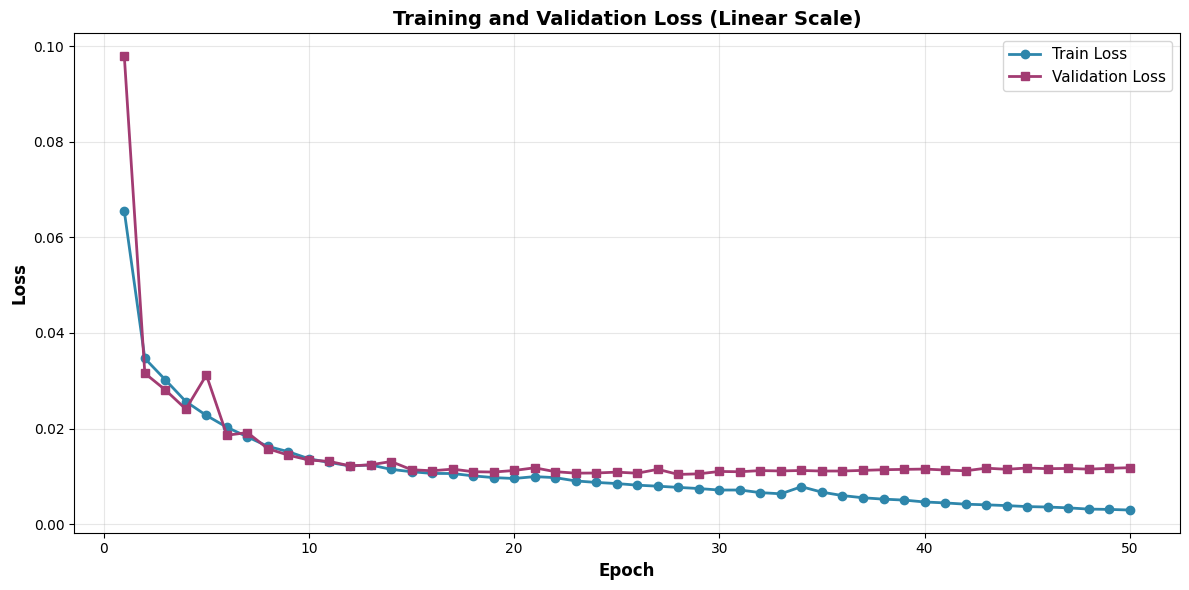

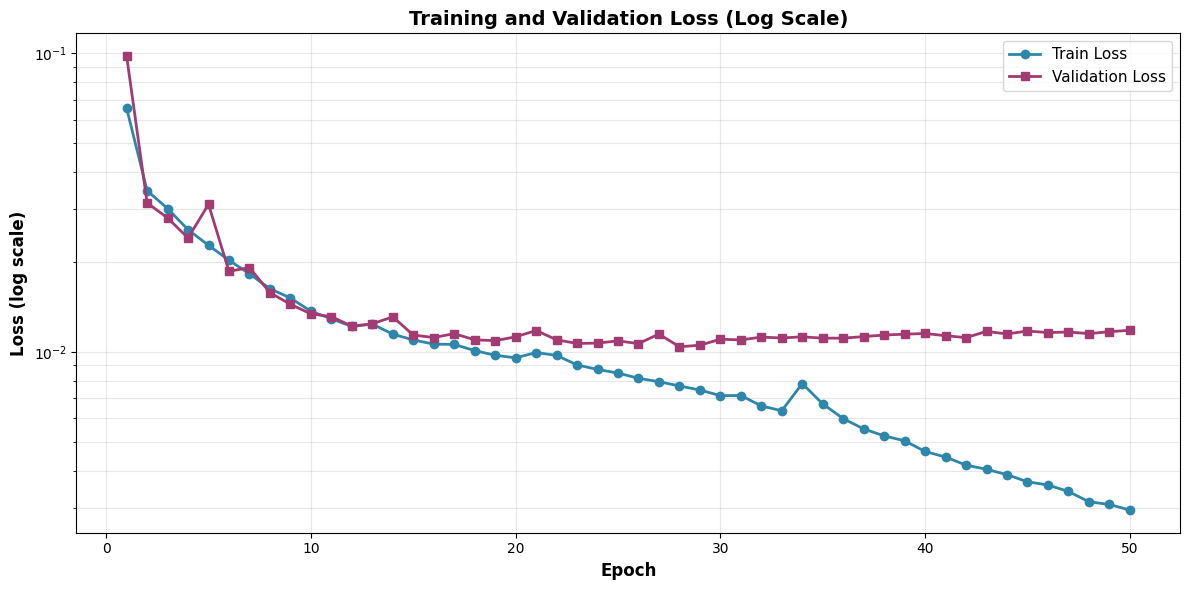

TRAINING SUMMARY
Total Epochs: 50
Best Validation Loss: 0.010397 at Epoch 28
Final Train Loss: 0.002951
Final Val Loss: 0.011809
Improvement (Train): 0.062527
Improvement (Val): 0.087556


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Extract loss arrays from model_0_results
train_losses = model_0_results["train_loss"]
test_losses = model_0_results["test_loss"]

epochs = np.arange(1, len(train_losses) + 1)

# Plot 1: Linear scale
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(epochs, train_losses, marker='o', linewidth=2, label="Train Loss", color='#2E86AB')
ax.plot(epochs, test_losses, marker='s', linewidth=2, label="Validation Loss", color='#A23B72')
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Loss", fontsize=12, fontweight='bold')
ax.set_title("Training and Validation Loss (Linear Scale)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig("loss_curve_linear.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Log scale (for better visualization of small changes)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(epochs, train_losses, marker='o', linewidth=2, label="Train Loss", color='#2E86AB')
ax.plot(epochs, test_losses, marker='s', linewidth=2, label="Validation Loss", color='#A23B72')
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Loss (log scale)", fontsize=12, fontweight='bold')
ax.set_title("Training and Validation Loss (Log Scale)", fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig("loss_curve_log.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
best_val_epoch = int(np.argmin(test_losses)) + 1
best_val_loss = min(test_losses)
final_train_loss = train_losses[-1]
final_val_loss = test_losses[-1]

print("=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Total Epochs: {len(train_losses)}")
print(f"Best Validation Loss: {best_val_loss:.6f} at Epoch {best_val_epoch}")
print(f"Final Train Loss: {final_train_loss:.6f}")
print(f"Final Val Loss: {final_val_loss:.6f}")
print(f"Improvement (Train): {train_losses[0] - final_train_loss:.6f}")
print(f"Improvement (Val): {test_losses[0] - best_val_loss:.6f}")
print("=" * 60)

Random sample index: 383
Filename: 0313-2_31260.jpg
Image shape: torch.Size([3, 224, 224])
True mask shape: torch.Size([1, 224, 224])
Predicted mask shape: torch.Size([1, 224, 224])


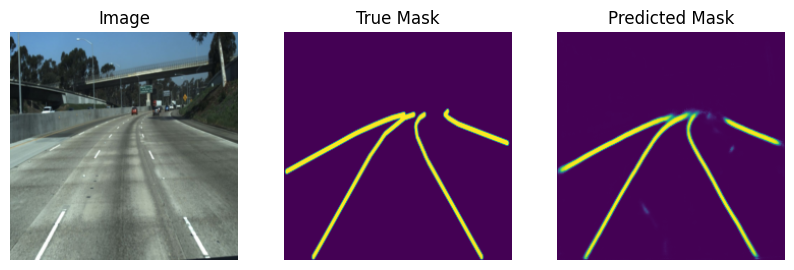

In [41]:
import random

# Display model prediction with random image from test dataset

# Select a random image from test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
image, true_mask = test_dataset[random_idx]
filename = test_dataset.image_files[random_idx]

# Generate prediction
model_0.eval()
with torch.no_grad():
    input_batch = image.unsqueeze(0).to(device)
    prediction = model_0(input_batch)
    pred_mask = (prediction).float().squeeze(0).cpu()

print(f"Random sample index: {random_idx}")
print(f"Filename: {filename}")
print(f"Image shape: {image.shape}")
print(f"True mask shape: {true_mask.shape}")
print(f"Predicted mask shape: {pred_mask.shape}")

# Display the three images side by side
display_sample([image, true_mask, pred_mask])

In [42]:
# Calculate metrics for the current sample (random_idx = 383)
with torch.no_grad():
    # Convert masks to binary (threshold at 0.5 for prediction)
    pred_binary = (pred_mask > 0.5).float()
    true_binary = true_mask.float()
    
    # Calculate individual metrics
    dice_coef = dice_coefficient(true_binary, pred_mask)
    acc = accuracy(true_binary, pred_mask)
    recall = recall_smooth(true_binary, pred_mask)
    precision = precision_smooth(true_binary, pred_mask)
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    # Calculate IoU (Intersection over Union)
    pred_flat = pred_binary.flatten()
    true_flat = true_binary.flatten()
    intersection = torch.sum(pred_flat * true_flat)
    union = torch.sum(pred_flat) + torch.sum(true_flat) - intersection
    iou = intersection / (union + 1e-7)
    
    print(f"Metrics for sample {random_idx} ({filename}):")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"IoU (Intersection over Union): {iou:.4f}")
    print(f"Dice Coefficient: {dice_coef:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

Metrics for sample 383 (0313-2_31260.jpg):
Accuracy: 0.9844
F1 Score: 0.7642
IoU (Intersection over Union): 0.7035
Dice Coefficient: 0.7643
Precision: 0.7636
Recall: 0.7648


In [45]:
# Quick evaluation on 10 random test samples
import random
import torch
import numpy as np
from statistics import mean, stdev

# number of samples to evaluate
N = 10
N = min(N, len(test_dataset))

indices = random.sample(range(len(test_dataset)), N)

results = []

model_0.eval()
with torch.no_grad():
    for i, idx in enumerate(indices):
        image, true_mask = test_dataset[idx]
        fname = test_dataset.image_files[idx]

        # forward
        inp = image.unsqueeze(0).to(device)
        pred = model_0(inp)                     # (1,1,H,W) or (1,1,H,W) probs
        pred_mask = pred.squeeze(0).cpu()       # (1,H,W)

        # binaries
        pred_binary = (pred_mask > 0.5).float()
        true_binary = true_mask.float()

        # metrics (use the functions already defined in notebook)
        dice_coef = dice_coefficient(true_binary, pred_mask).item()
        acc = accuracy(true_binary, pred_mask).item()
        recall = recall_smooth(true_binary, pred_mask).item()
        precision = precision_smooth(true_binary, pred_mask).item()
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

        # IoU
        pred_flat = pred_binary.flatten()
        true_flat = true_binary.flatten()
        intersection = torch.sum(pred_flat * true_flat)
        union = torch.sum(pred_flat) + torch.sum(true_flat) - intersection
        iou = (intersection / (union + 1e-7)).item()

        results.append({
            "idx": idx,
            "file": fname,
            "accuracy": acc,
            "f1": float(f1_score),
            "iou": iou,
            "dice": dice_coef,
            "precision": precision,
            "recall": recall
        })

        # print summary for this sample
        print(f"[{i+1}/{N}] idx={idx} file={fname}  Acc={acc:.4f}  F1={f1_score:.4f}  IoU={iou:.4f}  Dice={dice_coef:.4f}  P={precision:.4f}  R={recall:.4f}")

        # display images (Image, True mask, Predicted binary mask)
        # display_sample([image, true_mask, pred_binary.squeeze(0)])

# aggregate
metrics = ["accuracy","f1","iou","dice","precision","recall"]
agg = {}
for m in metrics:
    vals = [r[m] for r in results]
    agg[m] = {"mean": float(np.mean(vals)), "std": float(np.std(vals))}

print(f"\nAggregated (N={N}%):")
for m in metrics:
    print(f" {m:9s}: mean={agg[m]['mean']:.4f}  std={agg[m]['std']:.4f}")

[1/10] idx=290 file=0313-2_13260.jpg  Acc=0.9760  F1=0.6882  IoU=0.5758  Dice=0.6882  P=0.6924  R=0.6840
[2/10] idx=177 file=0313-1_43560.jpg  Acc=0.9737  F1=0.6436  IoU=0.5302  Dice=0.6436  P=0.5986  R=0.6959
[3/10] idx=148 file=0313-1_37740.jpg  Acc=0.9800  F1=0.7266  IoU=0.6406  Dice=0.7266  P=0.7178  R=0.7356
[4/10] idx=634 file=0531_1492726644992057700.jpg  Acc=0.9816  F1=0.6839  IoU=0.5815  Dice=0.6840  P=0.6691  R=0.6993
[5/10] idx=68 file=0313-1_17380.jpg  Acc=0.9839  F1=0.6896  IoU=0.6095  Dice=0.6897  P=0.6907  R=0.6885
[6/10] idx=488 file=0313-2_41220.jpg  Acc=0.9857  F1=0.7137  IoU=0.6448  Dice=0.7138  P=0.7009  R=0.7270
[7/10] idx=275 file=0313-2_1160.jpg  Acc=0.9774  F1=0.6900  IoU=0.5835  Dice=0.6900  P=0.6528  R=0.7316
[8/10] idx=279 file=0313-2_12300.jpg  Acc=0.9806  F1=0.7343  IoU=0.6491  Dice=0.7344  P=0.7230  R=0.7460
[9/10] idx=333 file=0313-2_19260.jpg  Acc=0.9824  F1=0.7600  IoU=0.6834  Dice=0.7601  P=0.7438  R=0.7770
[10/10] idx=185 file=0313-1_4540.jpg  Acc=0.9